In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import StratifiedGroupKFold

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

np.random.seed(42)


In [45]:
train = pd.read_csv('feat_sel_training_data.csv')
test = pd.read_csv('feat_sel_testing_data.csv')


___ 

## Data preprocessing

We need to scale our numeric data so that we don't get overweighting in some models. We will use a MinMaxScaler to scale between 0 and 1, meaning that we won't affect our One-Hot Encoded columns

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   accident_index                           11337 non-null  int64  
 1   accident_year                            11337 non-null  int64  
 2   number_of_vehicles                       11337 non-null  int64  
 3   number_of_casualties                     11337 non-null  int64  
 4   first_road_class                         11337 non-null  object 
 5   road_type                                11337 non-null  object 
 6   speed_limit                              11337 non-null  float64
 7   junction_detail                          11337 non-null  object 
 8   second_road_class                        11337 non-null  object 
 9   pedestrian_crossing_physical_facilities  11337 non-null  object 
 10  light_conditions                         11337


Speed limit, Years, and age_bands should be categorical and ordered.



In [47]:
speed_lims = train.speed_limit.value_counts().sort_index().index
years = train.accident_year.value_counts().sort_index().index
age_bands = ['0 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25', '26 - 35', '36 - 45', '46 - 55', '56 - 65', '66 - 75', 'Over 75']

for data in [train, test]:
  data['speed_limit'] = pd.Categorical(values=data['speed_limit'], categories=speed_lims, ordered=True)
  data['accident_year'] = pd.Categorical(values=data['accident_year'], categories=years, ordered=True)
  data['age_band_of_casualty'] = pd.Categorical(data['age_band_of_casualty'], ordered=True, categories=age_bands)



We don't really want to encode our date/time features as numeric as we will impose restrictions on our model, i.e. expecting severity to linearly increase with hour. Let's sin/cosine encode it for now to preserve the cyclical nature, but potentially we should bucket the Hours and Months.

In [ ]:
for data in [train, test]:
  data['day_sin'] = np.sin(data['Day'] * (2 * np.pi / data['Day'].max()))
  data['day_cos'] = np.cos(data['Day'] * (2 * np.pi / data['Day'].max()))
  data['month_sin'] = np.sin(data['Month'] * (2 * np.pi / data['Month'].max()))
  data['month_cos'] = np.cos(data['Month'] * (2 * np.pi / data['Month'].max()))
  data['hour_sin'] = np.sin(data['Hour'] * (2 * np.pi / data['Hour'].max()))
  data['hour_cos'] = np.cos(data['Hour'] * (2 * np.pi / data['Hour'].max()))
  data.drop(columns=['Day', 'Month', 'Hour'], axis=1, inplace=True)

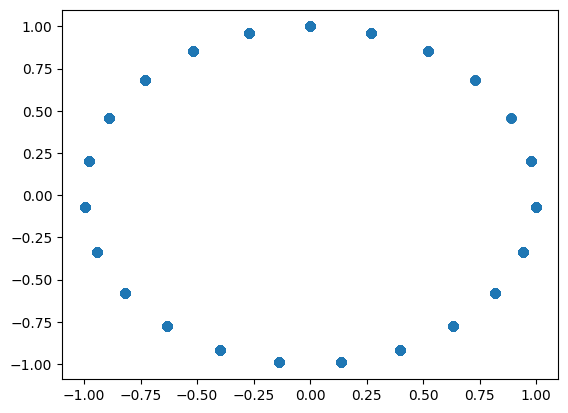

In [49]:
plt.scatter(train['hour_sin'], train['hour_cos'])


* Numeric features need scaling
* Ordinal features need numerical encoding
* Nomial features can be one-hot-encoded

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   accident_index                           11337 non-null  int64   
 1   accident_year                            11337 non-null  category
 2   number_of_vehicles                       11337 non-null  int64   
 3   number_of_casualties                     11337 non-null  int64   
 4   first_road_class                         11337 non-null  object  
 5   road_type                                11337 non-null  object  
 6   speed_limit                              11337 non-null  category
 7   junction_detail                          11337 non-null  object  
 8   second_road_class                        11337 non-null  object  
 9   pedestrian_crossing_physical_facilities  11337 non-null  object  
 10  light_conditions                  

In [51]:
boolean_feats = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
     
for dataset in [train, test]:
  for col in boolean_feats:
    dataset[col].replace({dataset[col].value_counts().index[0]: 0, dataset[col].value_counts().index[1]: 1}, inplace=True)

    
numeric_feats = ['number_of_vehicles', 'number_of_casualties']
ordinal_feats = list(train.select_dtypes(include='category').columns)
nominal_feats = list(train.select_dtypes(exclude=[np.number, bool, 'category']).columns)

### Scaling numericals

In [52]:
scaler = MinMaxScaler()
train[numeric_feats] = scaler.fit_transform(train[numeric_feats])
test[numeric_feats] = scaler.transform(test[numeric_feats])

### Ordinal encoding

In [53]:
year_codes = dict(zip(train.accident_year.cat.categories, np.arange(0, len(train.accident_year.cat.categories) + 1, 1)))
speed_limit_codes = dict(zip(train.speed_limit.cat.categories, np.arange(0, len(train.speed_limit.cat.categories) + 1, 1)))
age_band_codes = dict(zip(train.age_band_of_casualty.cat.categories, np.arange(0, len(train.age_band_of_casualty.cat.categories) + 1, 1)))

for data in [train, test]:
  data['accident_year'].replace(year_codes, inplace=True)
  data['speed_limit'].replace(speed_limit_codes, inplace=True)
  data['age_band_of_casualty'].replace(age_band_codes, inplace=True)

In [54]:
for data in [train, test]:
  data[ordinal_feats] = data[ordinal_feats].apply(lambda x: x.cat.codes)

#### One-hot encoding

In [55]:
train = pd.get_dummies(train, columns=nominal_feats)
test = pd.get_dummies(test, columns=nominal_feats)


In [56]:
(train.columns == test.columns).all()

True

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 64 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   accident_index                                                                                                     11337 non-null  int64  
 1   accident_year                                                                                                      11337 non-null  int8   
 2   number_of_vehicles                                                                                                 11337 non-null  float64
 3   number_of_casualties                                                                                               11337 non-null  float64
 4   speed_limit           

So we've got 59 total features, along with out predictor. Let's see what happens when we test some different models.

___
## Initial modelling

It is incredibly important to make sure there is no leakage between the training and validation datasets that we use to train our model during cross-fold validation.

Not only do we need to consider stratification (so that the class distributions are reflected in the folds), we also need to consider the grouping (by accident index) of our rows.

Thankfully, SKlearn has a handy variation of the k-fold splitting called StratifiedGroupKFold which will handle this for us. We can even feed this k-fold variation directly into the cross_val_score function to handle everything for us. We just need to pass in the information about how to group the data.

In [81]:
groups = train['accident_index'].copy().tolist()

In [82]:
y_train = train['casualty_severity']
X_train = train.drop(['casualty_severity'], axis=1)

y_test = test['casualty_severity']
X_test = test.drop(['casualty_severity'], axis=1)

In [83]:
X_train.head()

,accident_index,accident_year,number_of_vehicles,number_of_casualties,speed_limit,urban_or_rural_area,trunk_road_flag,sex_of_casualty,age_band_of_casualty,high_winds,...,car_passenger_Front seat passenger,car_passenger_Not car passenger,car_passenger_Rear seat passenger,casualty_type_Car occupant,casualty_type_Cyclist,casualty_type_Large Vehicle,casualty_type_Mobility scooter rider,casualty_type_Motorcycle,casualty_type_Other,casualty_type_Pedestrian
0,2022141225261,3,0.142857,0.1250,2,0,0,0,6,0,...,False,True,False,True,False,False,False,False,False,False
1,2022141225261,3,0.142857,0.1250,2,0,0,0,6,0,...,False,True,False,True,False,False,False,False,False,False
2,2022141225261,3,0.142857,0.1250,2,0,0,0,6,0,...,False,True,False,True,False,False,False,False,False,False
3,2023141320860,4,0.142857,0.0000,1,0,0,1,5,0,...,False,True,False,True,False,False,False,False,False,False
4,2019140899675,0,0.142857,0.0625,4,1,0,1,6,0,...,True,False,False,True,False,False,False,False,False,False


In [84]:
def evaluate_model(model_class, X_train=X_train, y_train=y_train):
    gkf = StratifiedGroupKFold(n_splits=5, shuffle=True)

    # Stratified Group K fold cross validation and predict on training data without data leakage from multiple casualties per collision
    accuracy_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=gkf, scoring='accuracy', groups=groups) * 100
    precision_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=gkf, scoring='precision', groups=groups) * 100
    recall_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=gkf, scoring='recall', groups=groups) * 100
    f1_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=gkf, scoring='f1', groups=groups) * 100
    

    metrics_dict = {
        'Model Type': model_class,
        'CV_mean_accuracy': np.round(accuracy_scores.mean(), 1), 
        'CV_mean_precision':np.round(precision_scores.mean(), 1), 
        'CV_mean_recall': np.round(recall_scores.mean(), 1), 
        'CV_mean_F1': np.round(f1_scores.mean(), 1)
        
       
    }   

    return metrics_dict

In [85]:
models = {'KNN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(), 'XGBoost': XGBClassifier()}  
model_metric_dict = {}

for key, values in models.items():
  pred = values.fit(X_train, y_train).predict(X_train)
  print(f"\nClassification Report ({key}):")
  print(classification_report(y_train, pred))


Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8156
           1       0.28      0.22      0.25      3181

    accuracy                           0.62     11337
   macro avg       0.50      0.50      0.50     11337
weighted avg       0.60      0.62      0.61     11337


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8156
           1       1.00      1.00      1.00      3181

    accuracy                           1.00     11337
   macro avg       1.00      1.00      1.00     11337
weighted avg       1.00      1.00      1.00     11337


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      8156
           1       0.97      0.78      0.86      3181

    accuracy                           0.93     11337
   macro avg       0.94 

In [86]:
for key, values in models.items():
  metrics_dict = evaluate_model(values)
  model_metric_dict.update({key: metrics_dict})

results = pd.DataFrame.from_dict(model_metric_dict).T.round(2)
results.sort_values(by='CV_mean_recall', ascending=False)

,Model Type,CV_mean_accuracy,CV_mean_precision,CV_mean_recall,CV_mean_F1
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",69.5,42.7,24.0,32.2
KNN,KNeighborsClassifier(),61.3,27.0,19.9,23.9
Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",71.7,48.4,14.1,22.2


We're clearly __massively__ overfitting to our training data. 

With our RF classifier, we have nearly 100% f1 score (the model predicts the correct outcome for every collision) without any cross-fold validation. With 5-fold stratified cross-validation using grouping (so there is no leakage of collisions with the same accident_index between the training and validation folds), the f1 score of all of our models drops dramatically. For the RF model, this is down to 22% - lower than the dummy classifier.

The only model that beats the dummy classifier is the XGBoost model, and even then we are #at 0.32 versus 0.27 for the dummy classifier. Although this is an 18.5% relative improvement in the model performance, so not to be discounted.

We need to revisit feature engineering to improve the generalisability of the model and reduce the overfitting.

Importantly, these cross-validated F1 scores are __significantly__ lower than without the grouping in the K-fold cross-validation. This shows that without using this technique we were experiencing significant data leakeage during training cross-validaiton which would severely impact the performance of our model on __truly__ unseen data.